Suspicious mail Detection:


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import TransformerMixin
from sklearn.preprocessing import LabelEncoder

In [12]:
def load_dataset(file_path):

    return pd.read_csv(file_path)

Email text processing:
-cleaning and transforming raw email text data into a format that is suitable for analysis or machine learning tasks
Here are some of the key email text preprocessing steps:

Lowercasing:
Removing Stopwords:
Lemmatization:
Handling Missing Values:
The combination of these preprocessing steps results in a clean and standardized representation of email text data, suitable for various natural language processing (NLP) tasks or machine learning models.

In [13]:
class TextPreprocessor(TransformerMixin):
    def transform(self, X, **transform_params):
        X = X.apply(self.clean_text)
        return X

    def fit(self, X, y=None, **fit_params):
        return self

    def clean_text(self, text):
        text = text.lower()
        text = ''.join([char for char in text if char.isalpha() or char.isspace()])
        text = ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])
        return text

def preprocess_data(df):
    df = df.dropna()
    features = df[['Email Text']].copy()
    preprocessor = TextPreprocessor()
    features['Email Text'] = preprocessor.fit_transform(features['Email Text'])
    return features, df['Email Type']

Training and testing:
We split our preprocessed data into two main subsets:

Training Set: to train our model. Model recognizes patterns and trends on the basis of this set.
Testing set: The testing set is reserved for evaluating the models' performance. It contains data that the models have not seen during training.

We typically follow a common split ratio, allocating approximately 80% of the preprocessed data to the training set and 20% to the testing set. Adjusting the split ratio may be necessary depending on the dataset size and specific requirements.


In [14]:
def train_nb_model(X_train, y_train):
    vectorizer = CountVectorizer()
    X_train_vectorized = vectorizer.fit_transform(X_train)
    nb_model = MultinomialNB()
    nb_model.fit(X_train_vectorized, y_train)
    return nb_model, vectorizer

def train_rf_model(X_train, y_train):
    vectorizer = CountVectorizer()
    X_train_vectorized = vectorizer.fit_transform(X_train)
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_vectorized, y_train)
    return rf_model, vectorizer

def train_svm_model(X_train, y_train):
    vectorizer = CountVectorizer()
    X_train_vectorized = vectorizer.fit_transform(X_train)
    svm_model = SVC(probability=True)
    svm_model.fit(X_train_vectorized, y_train)
    return svm_model, vectorizer

In [15]:
from sklearn.metrics import f1_score, precision_score

def evaluate_model(model, X_test, y_test, df):
    y_pred = model.predict(X_test)
    label_encoder = LabelEncoder()
    y_test_encoded = label_encoder.fit_transform(y_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label='Phishing Email')  # Calculate Precision
    f1 = f1_score(y_test, y_pred, pos_label='Phishing Email')  # Calculate F1 score
    
    print(f"Accuracy: {accuracy:.2f}")
    print("Precision:", precision)
    print("F1 Score:", f1)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=df['Email Type'].unique(), yticklabels=df['Email Type'].unique())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test_encoded, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    return accuracy, precision, f1, roc_auc

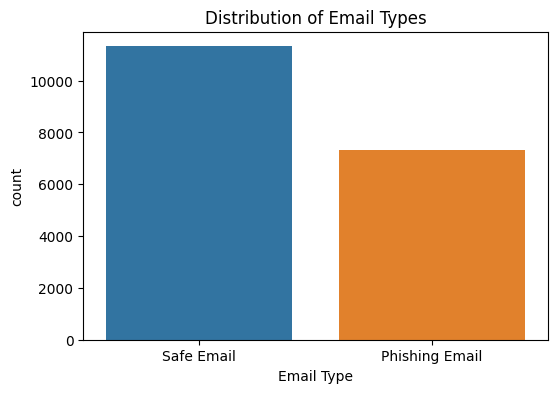

In [16]:
file_path = "Phishing_Email.csv"
df = load_dataset(file_path)

X, y = preprocess_data(df)


plt.figure(figsize=(6, 4))
sns.countplot(x='Email Type', data=df)
plt.title('Distribution of Email Types')
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X['Email Text'], y, test_size=0.2, random_state=42)

NAIVE BAYES:
Naive Bayes is a probabilistic machine learning algorithm widely used for classifying emails, especially in the context of phishing detection. It calculates the probability that an email belongs to a particular class (phishing or not) based on the occurrence of specific words and features.

RANDOM FOREST:
Random Forest is a robust ensemble learning algorithm that excels in classifying phishing emails. By constructing multiple decision trees during training and combining their predictions, Random Forest can effectively capture complex patterns and relationships in email text.

SVM: Support Vector Machine (SVM) is a powerful classification algorithm known for its effectiveness in identifying patterns in data. When applied to phishing email detection, SVM seeks an optimal hyperplane to separate phishing emails from legitimate ones. 



In [17]:
nb_model, nb_vectorizer = train_nb_model(X_train, y_train)

Naive Bayes Model Evaluation:
Accuracy: 0.95
Precision: 0.9601921757035004
F1 Score: 0.9405042016806723

Classification Report:
                 precision    recall  f1-score   support

Phishing Email       0.96      0.92      0.94      1518
    Safe Email       0.95      0.97      0.96      2209

      accuracy                           0.95      3727
     macro avg       0.95      0.95      0.95      3727
  weighted avg       0.95      0.95      0.95      3727



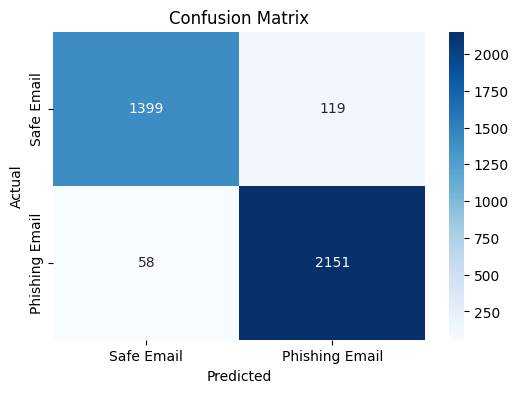

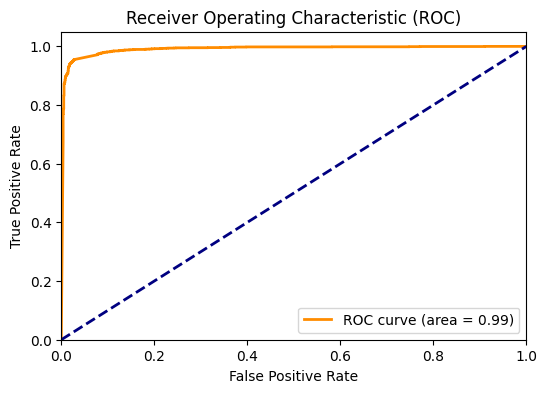

ROC-AUC: 0.9901331897119879


In [18]:
print("Naive Bayes Model Evaluation:")
nb_accuracy, nb_precision, nb_f1, nb_roc_auc = evaluate_model(nb_model, nb_vectorizer.transform(X_test), y_test, df)
print("ROC-AUC:", nb_roc_auc)

In [19]:
rf_model, rf_vectorizer = train_rf_model(X_train, y_train)

In [ ]:
print("\nRandom Forest Model Evaluation:")
rf_accuracy, rf_precision, rf_f1, rf_roc_auc = evaluate_model(rf_model, rf_vectorizer.transform(X_test), y_test, df)
print("ROC-AUC:", rf_roc_auc)

In [ ]:
svm_model, svm_vectorizer = train_svm_model(X_train, y_train)

NameError: name 'X_train' is not defined

In [ ]:
print("\nSVM Model Evaluation:")
svm_accuracy, svm_precision, svm_f1, svm_roc_auc = evaluate_model(svm_model, svm_vectorizer.transform(X_test), y_test, df)
print("ROC-AUC:", svm_roc_auc)


SVM Model Evaluation:


NameError: name 'svm_model' is not defined

In [ ]:
print("\nClassifier Comparison:\n")
print("Naive Bayes Accuracy:", nb_accuracy)
print("Random Forest Accuracy:", rf_accuracy)
print("SVM Accuracy:", svm_accuracy)
print("\nNaive Bayes Precision:", nb_precision)
print("Random Forest Precision:", rf_precision)
print("SVM Precision:", svm_precision)
print("\nNaive Bayes F1 Score:", nb_f1)
print("Random Forest F1 Score:", rf_f1)
print("SVM F1 Score:", svm_f1)
print("\nNaive Bayes ROC-AUC:", nb_roc_auc)
print("Random Forest ROC-AUC:", rf_roc_auc)
print("SVM ROC-AUC:", svm_roc_auc)

import numpy as np
import matplotlib.pyplot as plt

classifiers = ['Naive Bayes', 'Random Forest', 'SVM']
accuracy_values = [nb_accuracy, rf_accuracy, svm_accuracy]
precision_values = [nb_precision, rf_precision, svm_precision]
f1_values = [nb_f1, rf_f1, svm_f1]
roc_auc_values = [nb_roc_auc, rf_roc_auc, svm_roc_auc]

# Plot Accuracy
fig, ax = plt.subplots(figsize=(6, 4))
width = 0.4
x = np.arange(len(classifiers))
bars = ax.bar(x, accuracy_values, width=width, label='Accuracy', color='darkblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 3), ha='center', va='bottom', color='white')

ax.set_xticks(x)
ax.set_xticklabels(classifiers)
ax.legend()
ax.set_ylabel('Score')
plt.title('Accuracy Comparison')
plt.show()

# Plot Precision and F1-Score
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(classifiers, precision_values, marker='o', label='Precision', color='darkred')
ax.plot(classifiers, f1_values, marker='o', label='F1-Score', color='darkorange')

for i, value in enumerate(precision_values):
    plt.text(i, value + 0.01, f'{round(value, 3)}', ha='center', va='bottom', color='darkred')

for i, value in enumerate(f1_values):
    plt.text(i, value - 0.01, f'{round(value, 3)}', ha='center', va='top', color='darkorange')

ax.legend()
ax.set_ylabel('Score')
plt.title('Precision and F1-Score Comparison')
plt.show()

# Plot ROC-AUC
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(classifiers, roc_auc_values, marker='o', label='ROC-AUC', color='darkgreen')

for i, value in enumerate(roc_auc_values):
    plt.text(i, value + 0.01, round(value, 3), ha='center', va='bottom', color='white')

ax.legend()
ax.set_ylabel('Score')
plt.title('ROC-AUC Comparison')
plt.show()